In [15]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import scipy as sci

Here we:
1. Generally subset the Anndata object to only the markers that have been used to determine the annotation (from both the reference and the curated genes) - around 200 genes. (Actually we separate the Anndata obj. by cluster-specific genes, e.g. we have a subset object for each cluster (based on the genes but actually still containing all cells of all clusters) rather than a single object with all annotation genes).
2. Then in a single object containing the cluster-specific genes, the mean of these genes is calculated between the columns (genes represent columns) yielding a single cluster-specific metagene (with number of rows, e.g. all cells in the dataset preserved)
3. These metagenes exist for both the underexpressed annotaion markers and the overexpressed ones and are considered to be representative of their corresponding clusters.
4. The mean values to produce a metagene were calculated using then sparse csr_matrix mean() method.
5. Then the separate sparse matrices with cluster specific metagenes were concatenated using the sparse matrix method hstack() to generate the final sparse matrix containing all metagenes for all clusters. Here, even though dropout events could still cause a large amount of zeroes for some genes (as the genes are cluster-specific which implies they are mostly lowly expressed in the other clusters) we assumed that keeping all cells in the dataset would not be cause significant problems for visualisation.
6. We produce embeddings plotting the metagenes of each cluster on the entire dataset for both lowly and highly expressed annotation markers.
7. We also make dotplots summarising the expression of all metagenes (in terms of number of cells and and expression intensity)

In [16]:
def markers(genes, clusters):
    markers_dict = {}
    for cl in genes.columns:
        markers_dict[cl] = genes[cl].dropna().tolist()
    return markers_dict

def metagene(markers_dict, data, gene_names):
    metagenes = []
    for cl in markers_dict.keys():
        genes = markers_dict[cl]
        var = data.var[gene_names].isin(genes)
        data = data[:, var].copy()
        x = data.X.copy() # in this dataset X is sparse, csr_matrix
        means = x.mean(axis=1) # mean over the meaningful counts in the sparse matrix
        metagenes.append(means)
    return metagenes

def create_anndata(metagenes, clusters, anndante):
    for i in range(len(metagenes)):
        metagenes[i] = csr_matrix(metagenes[i]).T
    new_sparse = hstack([meta.T for meta in metagenes]) #horisontally attach the metagenes to each other to form the final sparse matrix
    # sparse matrix as even though the counts for the markers were pooled and the number of markers is not enormous, the number of cells has not
    # been shrinked. In addition even after pooling there could be some zeros in the data.
    new_alldata = ad.AnnData(new_sparse)
    new_alldata.var['gene_name'] = pd.Categorical(clusters) # since each metagene is unique for each cluster and the number of metagenes in the final 
    #Anndata object is the number of the corresponding clusters
    new_alldata.var_names = clusters
    obs_names = list(anndante.obs_names)
    new_alldata.obs_names = obs_names
    return new_alldata


#Create both the dotplots and the embeddings
def plots(alldata, clusters, high_or_low, annotation):
    var_names=['gene_'+str(n) for n in range(0, 17)]
    sc.tl.dendrogram(alldata, groupby = clusters) # order clusters by similarity for the dotplot
    fig, ax = plt.subplots(figsize=(7,7))
    sc.pl.dotplot(alldata, groupby=clusters, standard_scale='var',\
                  var_names=var_names, ax=ax, show=False)
    ax.set_title(f'{high_or_low}ly expressed genes', fontsize=12, weight='bold')
    plt.savefig(f'{high_or_low}ly expressed genes.png', dpi=300, bbox_inches='tight')
    plt.show()
    for gene in var_names: # plot embeddings
        fig, ax = plt.subplots(figsize=(4,3))
        sc.pl.umap(alldata, color=gene, \
                   cmap='Reds', show=False, ax=ax)
        ax.set_title(f'{annotation[gene.index()]}', fontsize=12, weight='bold')
        plt.savefig(f'{gene}-{high_or_low}.png', dpi=300, bbox_inches='tight') 
        plt.show()


In [17]:
alldata = sc.read_h5ad(f'Anndata_Objects/Annotation/alldata.h5ad')
adata_backup = alldata.X.copy()
alldata.var.index = alldata.var["gene_name"] 
alldata = alldata [:, ~alldata.var_names.duplicated(keep='first')].copy()
alldata.obs_names_make_unique()


/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Mean-pooling of genes is done on normalised counts

In [18]:

alldata.X = alldata.layers['log1p_norm'].copy()

In [19]:
alldata

AnnData object with n_obs × n_vars = 63324 × 18071
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'leiden_res0.5', 'leiden_res2', 'scVI_res_0.5', 'manual_celltype_annotation'
    var: 'gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5', 'leiden_res2', 'leiden_r

We import the cluster-based gene lists of annotation markers in two dataframes of highly and lowly expressed genes. The gene marker lists can be in different length as NaNs are dropped in the functions

In [13]:
gh=pd.read_csv('gene_markers_high.csv')
gl=pd.read_csv('gene_markers_low.csv')

Get cluster-based dicts of markers

In [7]:
cl = alldata.obs['scVI_res_0.5'].unique() # get clusters
genes_high = markers(gh, cl)
genes_low =  markers(gl, cl)


Aggregate into metagenes

In [8]:
mgenes_high = metagene(genes_high, alldata)
mgenes_low = metagene(genes_low, alldata)
# print(mgenes_high)

Create a new Anndata object containing all cells and all metagenes correspondingly highly or lowly expressed (not put in the same object for convenience; there are significant overlaps among the highly and lowly expressed genes, albeit they mark distinct clusters in their highly or low expressed form)

In [9]:
adata_high = create_anndata(mgenes_high, cl, alldata)
adata_low = create_anndata(mgenes_low, cl, alldata)


Create names for the metagenes in the new Anndata, in our case 'gene_cluster number'

In [11]:
adata_high.var_names = ['gene_'+ x for x in adata_high.var_names]
adata_low.var_names = ['gene_'+ x for x in adata_low.var_names]

In [12]:
highdata = ad.concat([alldata, adata_high], axis=1, join='outer', merge='first').copy()
lowdata = ad.concat([alldata, adata_low], axis=1, join='outer', merge='first').copy()

Create all plots 

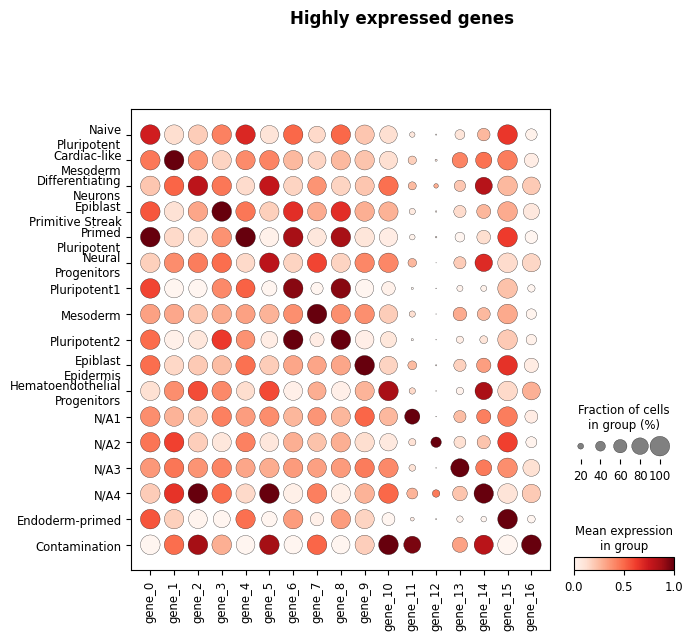

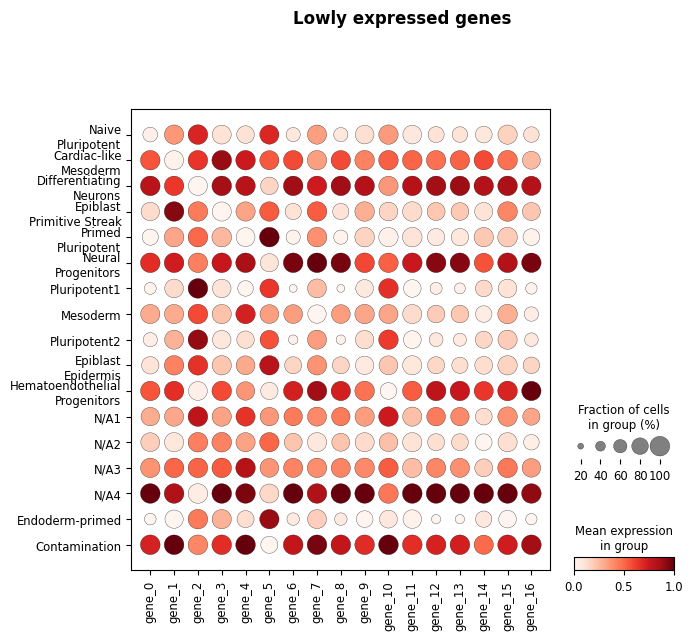

In [23]:
plots(highdata, cl, 'High')
plots(lowdata, cl, 'Low')


References:
Plots were made at the suggestion of V. Bhardwaj (github: bhardwaj-lab).